In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[16]:


import numpy as np
import astropy
from astropy.io import ascii
from astropy.table import Table
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Distance
import astropy.cosmology 
from astropy import cosmology
from astropy.cosmology import WMAP9
import pylab
import scipy
from scipy.integrate import simps
import astropy.constants as const
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import funcs
import astropy.units as u
from astropy.visualization.wcsaxes import SphericalCircle
import camb
from camb import get_matter_power_interpolator
from camb import model, initialpower
import colossus.cosmology
from colossus.cosmology import cosmology
import os
import asciitable
import regions
from regions import Regions
from regions import CircleSkyRegion, PixCoord, CirclePixelRegion
from regions import SkyRegion
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

#Working directory!!!
os.chdir('D:\HST')

In [2]:
#Cosmology initialisation
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
redshift=0.831

h = 0.7
omega_b  = 0.025
omega_m = 0.3
omega_c = omega_m - omega_b
omega_de=0.7
ns=0.965
cosmo=FlatLambdaCDM(H0=h*100, Om0=omega_m)
astropy_cosmo = astropy.cosmology.FlatLambdaCDM(H0=h*100, Om0=omega_m, Ob0=omega_b)
pars.set_cosmology(H0=h*100, ombh2= omega_b*h**2, omch2=omega_c*h**2, mnu=0.06, omk=0, tau=0.06)


pars.InitPower.set_params(As=2e-9, ns=ns, r=0)
pars.set_matter_power( kmax=500)#necessary 
pars.set_for_lmax(2500, lens_potential_accuracy=0)
#pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
PK = results.get_matter_power_interpolator(pars, k_hunit =False, hubble_units = False)
sigma_8=results.get_sigma8()


C=const.c.to(u.Mpc/u.s)

pi=np.pi
G=const.G
distance=3.0
zl=redshift
zs=distance
con=6.0

M_nl=10**14
M=1


astropy_cosmo.name='my_cosmo'
colossus_cosmo = cosmology.fromAstropy(astropy_cosmo, sigma_8, ns, name = 'my_cosmo')
D=colossus_cosmo.growthFactorUnnormalized(zl) # growth factor

r_200=1.0*u.Mpc
roh_c=cosmo.critical_density(zl).to(u.M_sun/u.Mpc**3)
roh_c0=cosmo.critical_density(0).to(u.M_sun/u.Mpc**3)
delta_c=roh_c-roh_c0
rohc0=roh_c0.value
rohc=roh_c.value
deltac=delta_c.value
r_xi=cosmo.comoving_distance(zl)
a=cosmo.scale_factor(zl)
D_s=cosmo.angular_diameter_distance(zs)
D_1=cosmo.angular_diameter_distance(zl)
D_1s=cosmo.angular_diameter_distance_z1z2(zl, zs)

loading
CL0152
5258.119920012135 Mpc


C:\ProgramData\Anaconda3\lib\site-packages\astropy\table\column.py:1153: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


number of 1 and 2 color objects inCL0152
(1785,)
(179,)


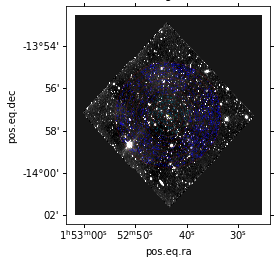

No handles with labels found to put in legend.


In [3]:


#loading data


cluster_name=("CL0152","CL1226" ,"El_Gordo" ,"ISCS1434+34","RCS2345","RDCS1252","XMMU1229","XMMU2235")    
#,"El_Gordo"     
#1 color cluster names not all working currently
#cluster_name=("CL0152","CL1226","CL1415","CL1604+4304","El_Gordo","ISCS1429","ISCS1432+33","ISCS1434+34","ISCS1438",
#              "RCS0220","RCS0337","RCS1511","RCS2345","RDCS0910","RDCS1252","XLSS0223","XMMU1229","XMMU2205","XMMU2235") 


def load_cat(name,z,minsep, minsep_2c,    rad_bincount):
    print("loading")
    print(name)
    Lambdar_cat_1=ascii.read("LAMBDAR_W3F/LAMBDAR_"+name+"_F105W_results.csv")
    Lambdar_cat_2=ascii.read("LAMBDAR_W3F/LAMBDAR_"+name+"_F775W_results.csv")
    Lambdar_cat_3=ascii.read("LAMBDAR_W3F/LAMBDAR_"+name+"_F850LP_results.csv")
    image1=fits.open(r"derot_weight/"+name+"_F775W_drc_sci_unrot_w.fits", memmap=True) 

    #producing combined catalog
    redshift=z
    redshift_d=Distance(z=redshift, cosmology=astropy_cosmo)
    print(redshift_d)
    wcs = WCS(image1[0].header)
    center_alpha=image1[0].header["CRVAL1"]
    center_delta=image1[0].header["CRVAL2"]

    #Turning NA into numerical values that depend on the filter used
    Lambdar_cat_1["ABMagErrDFA"][Lambdar_cat_1["ABMagErrDFA"]=="NA"]=100
    Lambdar_cat_1["ABMagDFA"][Lambdar_cat_1["ABMagDFA"]=="NA"]=100
    Lambdar_cat_2["ABMagErrDFA"][Lambdar_cat_2["ABMagErrDFA"]=="NA"]=200
    Lambdar_cat_2["ABMagDFA"][Lambdar_cat_2["ABMagDFA"]=="NA"]=200
    Lambdar_cat_3["ABMagErrDFA"][Lambdar_cat_3["ABMagErrDFA"]=="NA"]=300
    Lambdar_cat_3["ABMagDFA"][Lambdar_cat_3["ABMagDFA"]=="NA"]=300


    #creating combined catalog
    dt = {'names':['ID', "ALPHA_J2000","DELTA_J2000","F105W","F105W_err","F775W","F775W_err"
                   ,"F850LP","F850LP_err","distance","a_distance"], 
              'formats':[float, float, float, float, float, float, float,float,float,float,float]}
    comcat = np.zeros(len(Lambdar_cat_2), dtype=dt)
    comcat['ID']=Lambdar_cat_2["NUMBER"]
    comcat["ALPHA_J2000"]=Lambdar_cat_2["ALPHA_J2000"]
    comcat["DELTA_J2000"]=Lambdar_cat_2["DELTA_J2000"]
    comcat["F105W"]=Lambdar_cat_1["ABMagDFA"]
    comcat["F105W_err"]=Lambdar_cat_1["ABMagErrDFA"]
    comcat["F775W"]=Lambdar_cat_2["ABMagDFA"]
    comcat["F775W_err"]=Lambdar_cat_2["ABMagErrDFA"]
    comcat["F850LP"]=Lambdar_cat_3["ABMagDFA"]
    comcat["F850LP_err"]=Lambdar_cat_3["ABMagErrDFA"]
    #measuring real distance
    m1=SkyCoord(ra=image1[0].header["CRVAL1"]*u.degree, dec=image1[0].header["CRVAL2"]*u.degree, distance=redshift_d)
    m2=SkyCoord(ra=comcat["ALPHA_J2000"]*u.degree, dec=comcat["DELTA_J2000"]*u.degree, distance=redshift_d)
    distance=m1.separation_3d(m2)
    comcat["distance"]=distance
    a_distance=m1.separation(m2)
    comcat["a_distance"]=a_distance

    #cutting combined catalog

    #border cut
    
    m1=SkyCoord(ra=image1[0].header["CRVAL1"]*u.degree, dec=image1[0].header["CRVAL2"]*u.degree)
    m2=SkyCoord(ra=comcat["ALPHA_J2000"]*u.degree, dec=comcat["DELTA_J2000"]*u.degree)
    distance=m1.separation(m2)
    comcat2=comcat[distance < minsep*u.arcmin]
    comcat2color=comcat[distance < minsep_2c*u.arcmin]


    #region cut 1 color
    Region = Regions.read("Masks/cut_regions/"+name+"_WCS.reg", format='ds9')
    skycoord = SkyCoord(ra=comcat2["ALPHA_J2000"]*u.degree, dec=comcat2["DELTA_J2000"]*u.degree)    
    contains=np.logical_not(Region[0].contains(skycoord, wcs))
    for x in range(len(Region)):
        contains=np.logical_and(contains, np.logical_not(Region[x].contains(skycoord, wcs)))
    comcat3=comcat2[contains]
    
    
    #region cut 2 color
    Region = Regions.read("Masks/cut_regions/"+name+"_WCS.reg", format='ds9')
    skycoord = SkyCoord(ra=comcat2color["ALPHA_J2000"]*u.degree, dec=comcat2color["DELTA_J2000"]*u.degree)
    contains=np.logical_not(Region[0].contains(skycoord, wcs))
    for x in range(len(Region)):
        contains=np.logical_and(contains, np.logical_not(Region[x].contains(skycoord, wcs)))
    comcat3_2color=comcat2color[contains]
    
    #catalog for foreground correction

    reverse_cat=comcat3[(comcat3["F775W"]-comcat3["F850LP"])>0]
    
    
    
    
    #color cut
    #cut in 1 color
    #F775W-F850LP<0
    comcat4=comcat3[(comcat3["F775W"]-comcat3["F850LP"])<0]
    
    
    #cut in 2 colors 
    #F775W-F850LP<0
    #F850LP-105W<0.3
    comcat4_2color=comcat3_2color[(comcat3_2color["F775W"]-comcat3_2color["F850LP"])<0]
    comcat5_2color=comcat4_2color[comcat4_2color["F105W"]<50]
    comcat5_2color=comcat5_2color[(comcat5_2color["F850LP"]-comcat5_2color["F105W"])<0.3]
    print("number of 1 and 2 color objects in" +name)
    print(comcat4["distance"].shape)
    print(comcat5_2color["distance"].shape)
    
    #visualisation

    max_d=np.max(comcat4["a_distance"])
    ax = plt.subplot(projection=wcs)
    center=SkyCoord(ra=image1[0].header["CRVAL1"]*u.degree, dec=image1[0].header["CRVAL2"]*u.degree)
    ALPHA_L= comcat4["ALPHA_J2000"].astype("float64")
    DELTA_L=comcat4["DELTA_J2000"].astype("float64")
    ALPHA_L2= comcat5_2color["ALPHA_J2000"].astype("float64")
    DELTA_L2=comcat5_2color["DELTA_J2000"].astype("float64")
    ax.imshow(image1[0].data, vmin=-20, vmax=200, origin='lower', cmap="gray")
    ax.scatter(image1[0].header["CRVAL1"], image1[0].header["CRVAL2"], transform=ax.get_transform('fk5'), linewidths=0.05 ,edgecolor='yellow', facecolor='yellow', s=1)
    ax.scatter(ALPHA_L, DELTA_L, transform=ax.get_transform('fk5'), linewidths=0.3 ,edgecolor='blue', facecolor='none', s=0.2)
    ax.scatter(ALPHA_L2, DELTA_L2, transform=ax.get_transform('fk5'), linewidths=0.3 ,edgecolor='green', facecolor='none', s=0.2)
    for x in range(rad_bincount):
        s = SphericalCircle((image1[0].header["CRVAL1"]*u.degree, image1[0].header["CRVAL2"]*u.degree),(max_d * (x+1)/rad_bincount) * u.degree,
                    edgecolor='red', linewidth=0.1, facecolor='none',
                    transform=ax.get_transform('fk5'))
        ax.add_patch(s)
    ax.set_xlim(-500, image1[0].data.shape[1] + 500)
    ax.set_ylim(-500, image1[0].data.shape[0] + 500)
    pylab.title(x)
    pylab.savefig("./pipeline_tests/"+name+"_colorcut1+2cc ", dpi=2000)
    pylab.show()
    pylab.close('all')
    
    
    
    pylab.hist( comcat4["F775W"], bins=50, align='mid', density=False, alpha=1)

    pylab.xlabel('F775W')
    pylab.ylabel('N')
    pylab.legend(fontsize=8)

    pylab.title('Magnitude Histogramm '+name+' after cut')
    pylab.savefig("./pipeline_tests/"+name+"_histcolorcut1c ", dpi=1000)
    pylab.show
    pylab.close('all')
    
    return comcat4, reverse_cat, comcat5_2color

comcat4=load_cat("CL0152",0.831,2.5,1.0, 10)

adjusting for foreground objects in CL0152
5258.119920012135 Mpc


1000 pixel lenghts is
1.274602357364469 Mpc
1000 pixel lenghts is
1.2746022563299482


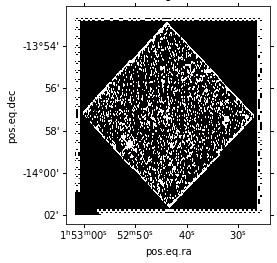

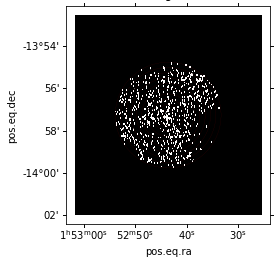

[1.93692032e+02 4.40627006e-02 5.31020365e-02 4.53298973e-02
 7.60301721e-02 8.12273028e-02 8.54464177e-02 8.78654635e-02
 9.71452418e-02 7.42642199e-02]


In [5]:
def foreground_adjust(name,z,colourcat,reverse_cat, rad_bincount):
    print("adjusting for foreground objects in "+name) 
    #loading segmentation map
    catalog=reverse_cat
    image1=fits.open(r"Segmentation_maps/"+name+"_F775W_drc_sci_unrot_w_seg.fits", memmap=True) 
    
    
    max_d=np.max(colourcat["distance"])
    
    redshift=z
    redshift_d=Distance(z=redshift, cosmology=astropy_cosmo)
    print(redshift_d)
    #going over image pixel by pixel
    wcs = WCS(image1[0].header)
    center_alpha=image1[0].header["CRVAL1"]
    center_delta=image1[0].header["CRVAL2"]
    m1=SkyCoord(ra=image1[0].header["CRVAL1"]*u.degree, dec=image1[0].header["CRVAL2"]*u.degree, distance=redshift_d)
    data=image1[0].data
    distarray=np.array(data, dtype=float)
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            if data[x][y]!=0:
                if np.any(catalog['ID']==data[x][y]):
                    sky0 = wcs.pixel_to_world(x, y)
                    sky=SkyCoord(ra=sky0.ra.degree*u.degree, dec=sky0.dec.degree*u.degree,frame="fk5", distance=redshift_d)
                    distance=m1.separation_3d(sky).value
                    distarray[x][y]=distance
                else:
                    distarray[x][y]=0
    counttot=np.arange(0+0.00001 ,max_d ,(max_d/rad_bincount), dtype=float)              
    #print(np.max(distarray))
    #print(max_d)
    
    
    #counting based on radial distances 
    for k in range(rad_bincount):
        lowlim=(k*max_d/rad_bincount)
        highlim=(k+1)*max_d/rad_bincount
        highcount=np.count_nonzero(distarray<highlim)
        lowcount=np.count_nonzero(distarray<lowlim)
        count=highcount-lowcount
        counttot[k]=count
        #print(lowlim)
        #print(highlim)
        #print(bins)
        #print(lowcount)
        #print(highcount)
    
        #print(count)
        #print(counttot)

        
        
    #determining pixelarea
    skyl = wcs.pixel_to_world(1000, 1000)
    skyl1=SkyCoord(ra=skyl.ra.degree*u.degree, dec=skyl.dec.degree*u.degree,distance=redshift_d)
    skyh = wcs.pixel_to_world(2000, 1000)
    skyh1=SkyCoord(ra=skyh.ra.degree*u.degree, dec=skyh.dec.degree*u.degree,distance=redshift_d)
    print("1000 pixel lenghts is")
    print(skyl1.separation_3d(skyh1))
    distance1000x=skyl1.separation_3d(skyh1).value
    skyh = wcs.pixel_to_world(1000, 2000)
    skyh1=SkyCoord(ra=skyh.ra.degree*u.degree, dec=skyh.dec.degree*u.degree,distance=redshift_d)
    distance1000y=skyl1.separation_3d(skyh1).value
    pixarea=(distance1000x*distance1000y/1000000)                
    forearea=counttot*pixarea
    #print(forearea)
    #print(skyl1.separation_3d(skyh1))
    
    print("1000 pixel lenghts is")
    print(distance1000y)
    
    #visualisation
    max_d=np.max(colourcat["a_distance"])
    ax = plt.subplot(projection=wcs)   
    ax.imshow(image1[0].data, vmin=0, vmax=0.0001, origin='lower', cmap="gray")
    for x in range(rad_bincount):
        s = SphericalCircle((image1[0].header["CRVAL1"]*u.degree, image1[0].header["CRVAL2"]*u.degree),(max_d * (x+1)/rad_bincount) * u.degree,
                    edgecolor='red', linewidth=0.05, facecolor='none',
                    transform=ax.get_transform('fk5'))
        ax.add_patch(s)
    ax.set_xlim(-500, image1[0].data.shape[1] + 500)
    ax.set_ylim(-500, image1[0].data.shape[0] + 500)
    pylab.title(x)
    pylab.savefig("./pipeline_tests/"+name+"_seg1c ", dpi=2000)
    pylab.show()
    pylab.close('all')
    
    
    
    
    ax = plt.subplot(projection=wcs)
    
    ax.imshow(distarray, vmin=0, vmax=0.0001, origin='lower', cmap="gray")
    
    
    for x in range(rad_bincount):
        s = SphericalCircle((image1[0].header["CRVAL1"]*u.degree, image1[0].header["CRVAL2"]*u.degree),(max_d * (x+1)/rad_bincount) * u.degree,
                    edgecolor='red', linewidth=0.05, facecolor='none',
                    transform=ax.get_transform('fk5'))
        ax.add_patch(s)
    ax.set_xlim(-500, image1[0].data.shape[1] + 500)
    ax.set_ylim(-500, image1[0].data.shape[0] + 500)
    pylab.title(x)
    pylab.savefig("./pipeline_tests/"+name+"_segrem1c ", dpi=2000)
    pylab.show()
    pylab.close('all')
    
    return forearea
print(foreground_adjust("CL0152",0.831,comcat4[0],comcat4[1], 10))

6.0
[0.93068705]
209641526897.977 solMass / Mpc3
345634474248.434 solMass / Mpc3
1588.921359074367 Mpc 1568.3890375185222 Mpc 870.9912771502635 Mpc
9.715611890180196e-15 Mpc / s   Name   = Gravitational constant
  Value  = 6.6743e-11
  Uncertainty  = 1.5e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2018
<function sigma_crit at 0x000001C02DE6F8B0>
0.16666666666666666
check
3.019139122084217e+21
[0.25 0.28 0.31 0.34 0.37 0.4  0.43 0.46 0.49 0.52 0.55 0.58 0.61 0.64
 0.67 0.7  0.73 0.76 0.79 0.82 0.85 0.88 0.91 0.94 0.97 1.   1.03 1.06
 1.09 1.12 1.15 1.18 1.21 1.24 1.27 1.3  1.33 1.36 1.39 1.42 1.45 1.48
 1.51 1.54 1.57 1.6  1.63 1.66 1.69 1.72 1.75 1.78 1.81 1.84 1.87 1.9
 1.93 1.96 1.99 2.02 2.05 2.08 2.11 2.14 2.17 2.2  2.23 2.26 2.29 2.32
 2.35 2.38 2.41 2.44 2.47 2.5  2.53 2.56 2.59 2.62 2.65 2.68 2.71 2.74
 2.77 2.8  2.83 2.86 2.89 2.92 2.95 2.98 3.01 3.04 3.07 3.1  3.13 3.16
 3.19 3.22]
[  -0.39524083   -0.43906533   -0.49989932   -0.57860258   -0.67835938
   -0.80473731   -0.9

<function matplotlib.pyplot.show(close=None, block=None)>

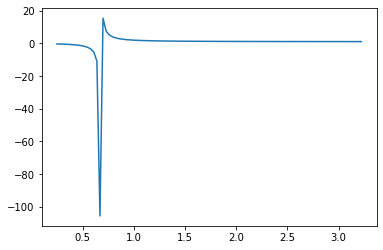

In [28]:
#Theoretical calcs

#calculating Beta

names=['x', 'y', 'F435W', 'F435We', 'F435Wa', 'F435Wae', 'F606W', 'F606We', 'F606Wa', 'F606Wae', 'F775W', 'F775We'
       , 'F775Wa', 'F775Wae', 'F850LP', 'F850LPe', 'F850LPa', 'F850LPae', 'z_w']
#colspecs = [(1, 5), (7, 12), (14, 23), (25, 34), (98, 105),(106, 113)] # for UDF
GOODS_cat=ascii.read("GOODS_photo_z/n-goods_z.cat", names=names)
GOODS_cat2=ascii.read("GOODS_photo_z/s-goods_z.cat", names=names)
GOODS_cat=astropy.table.vstack([GOODS_cat, GOODS_cat2], join_type='outer', metadata_conflicts='warn')

gdata=GOODS_cat.as_array()
f1=4
f1n='F775W'
#4
f2=5
f2n='F850LP'
#5
f3=6
f3n='F105W'


gdata=gdata[gdata['F775W']>26]
gdata=gdata[gdata['F775W']<28]
gdata=gdata[gdata[f1n]-gdata[f2n]<0]
Beta_sum=0.0
for x in range(gdata.shape[0]):   
    if zs<zl:
        Beta_temp=0.0
    
    else:
        Beta_temp=cosmo.angular_diameter_distance_z1z2(zl, zs)/cosmo.angular_diameter_distance(zs)
    Beta_sum=Beta_sum+Beta_temp
Beta=Beta_sum/gdata.shape[0]
print(Beta)


#model calculation needs a definition for what comcat is and currently not necessary
upmedlimit=2.5
downmedlimit=1.5
medcount=comcat["distance"][np.logical_and(comcat["distance"]>downmedlimit,comcat["distance"]<upmedlimit)].shape[0]
print(medcount)
Area=(np.pi*upmedlimit**2)-(np.pi*downmedlimit**2)


def n_0(count,Area):
    n_0=count/Area
    return n_0
    
def n_mod(n_0,mu,s):
    n_mod=n_0*mu**(2.5*s-1)
    return n_mod

s=0.6396017190333048

#sigma_crit


def sigma_crit(Beta,z,C,pi,G):
    D_l=cosmo.angular_diameter_distance(z)
    sigma_crit=((C**2)/(4*pi*G*Beta*D_l)).to((u.M_sun)/u.Mpc**2)
    return sigma_crit.value
print(sigma_crit(Beta,redshift,C,pi,G))


print(con)
print(sigma_8)
print(delta_c)
print(roh_c)
print(D_s, D_1, D_1s)
print(C, G)
"""def D(z):
    a=cosmo.scale_factor(z)
    y=np.arange(100)/100+10**-20
    return(2.5*omega_m*scipy.integrate.simps(1/((y**3)*(omega_m*y**-3+omega_de*(1-omega_m-omega_de)**-2)**1.5)), y)"""

Sigma_crit=sigma_crit(Beta,redshift,C,pi,G)
print(sigma_crit)
def b1(M, M_nl):
    x=M/M_nl
    return(0.53+0.39*(x**0.45)+(0.13/(40*x+1)+5*(10**-4)*(x**1.5)))
b_1=b1(M, M_nl)
def r_s(r_200, con):
    return(r_200/con)
rs=r_s(r_200, con).value
print(rs)
#def Sigma_crit(D_s, D_1, D_1s):
 #   return ((C.value**2)/(4*pi*G.value))*D_s/(D_1*D_1s)

def delta_c(con):
    return ((200*(con**3))/(3*np.log10(1+con)-(con/(1+con))))
check=((2*rs*deltac*rohc)/(((0.5/rs)**2)-1))#*(1-(2/np.sqrt(1-x**2))*np.arctanh(np.sqrt((1-x)/(1+x))))
print('check')
print(check)
def Sigma_NFW(R, r_s, delta_c, roh_c):
    x=(R/r_s)
    if x < 1.0:
        return(((2*r_s*delta_c*roh_c)/(((x**2)-1)*1000000))*(1-(2/np.sqrt(1-x**2))*np.arctanh(np.sqrt((1-x)/(1+x)))))
    elif x == 1.0:
        return((2*r_s*delta_c*roh_c)/(3*1000000))
    elif x > 1.0:
        return(((2*r_s*delta_c*roh_c)/(((x**2)-1)*1000000))*(1-(2/np.sqrt((x**2)-1))*np.arctan(np.sqrt((x-1)/(1+x)))))
    else:
        print('error: z not a number')
        return 0
    
def Sigma_NFW_bar(R, r_s, delta_c, roh_c):
    x=(R/r_s)
    if x < 1.0:
        return(((4*r_s*delta_c*roh_c)/((x**2)*1000000))*((2/np.sqrt(1-x**2))*np.arctanh(np.sqrt((1-x)/(1+x)))+np.log(x/2)))
    elif x == 1.0:
        return((4*r_s*delta_c*roh_c)*(1+np.log(1/2))/1000000)
    elif x > 1.0:
        return(((4*r_s*delta_c*roh_c)/((x**2)*1000000))*((2/np.sqrt((x**2)-1))*np.arctan(np.sqrt((x-1)/(1+x)))+np.log(x/2)))
    else:
        print('error: x not a number')
        return 0
vSigma_NFW=np.vectorize(Sigma_NFW)
def xi(r):
    k=10**(5*np.arange(500)/500 -3)
    #x_axis=np.arange(200)
    #for x in np.arange(200):
       # y_xi=10**(-3*np.arange(200)/200 +4)
       # x_axis[x]=(y_xi[x]**2)*((np.sin(y_xi[x]*r)/(y_xi[x]*r))*PK.P(zl, y_xi[x]))
    #print(x_axis)
    return((1/(2*(pi**2)))*scipy.integrate.simps((k**2)*((np.sin(k*r)/(k*r))*PK.P(0, k)), k))  
vxi=np.vectorize(xi)


def Sigma_1(R, z):
    y=np.arange( 100)/50
    #print(y)
    #print(R)
    #print(zxi((1+z)*np.sqrt((R**2)+(y**2))))
    # x_axis=y
    #for x in np.arange(200):
       # y=np.arange(-100, 100)*100
        #x_axis[x]=(xi((1+z)*np.sqrt((R**2)+(y[x]**2))))    
    return(((1+z)**3)*roh_c0.value*scipy.integrate.simps((vxi((1+z)*np.sqrt((R**2)+(y**2)))), y))
vSigma_1=np.vectorize(Sigma_1)
def Sigma_2Halo(R, z, b_1):
    return(b_1*omega_m*(sigma_8**2)*(D**2)*vSigma_1(R, z))

def Sigma_2Halo_bar(R, z, b_1):
    R_sign=R*(np.arange(200)/200+0.01)
    return(2/(R**2)*scipy.integrate.simps((R_sign*Sigma_2Halo(R_sign, z, b_1)), R_sign))

def kappa(R, z, r_s, delta_c, roh_c, b_1):
    return((Sigma_NFW(R, r_s, delta_c, roh_c)+Sigma_2Halo(R, z, b_1))/Sigma_crit)

def gamma(R, z, r_s, delta_c, roh_c, b_1):
    return((Sigma_2Halo_bar(R, z, b_1)-Sigma_2Halo(R, z, b_1)+Sigma_NFW_bar(R, r_s, delta_c, roh_c)-
            Sigma_NFW(R, r_s, delta_c, roh_c))/Sigma_crit)
def mu(R, z, r_s, delta_c, roh_c, b_1):
    return(1/(((1-kappa(R, z, r_s, delta_c, roh_c, b_1))**2)-(gamma(R, z, r_s, delta_c, roh_c, b_1)**2)))





#Testing all above
vmu=np.vectorize(mu)
vSigma_2Halo_bar=np.vectorize(Sigma_2Halo_bar)
vkappa=np.vectorize(kappa)
vgamma=np.vectorize(gamma)
vSigma_2Halo=np.vectorize(Sigma_2Halo)
R=np.arange(100)/100*3+0.25
vSigma_NFW=np.vectorize(Sigma_NFW)
vSigma_crit=np.vectorize(sigma_crit)

M=-20
M_star=-20.84
alpha_LF=-1.6
alpha=(10**(0.4*M_star-M))-alpha_LF-1
#w_lens=((alpha-1)**2)*(vmu(R, zl, rs, deltac, rohc)-1)
#w=(1/N)*np.sum(w_lens)



print(R)

yval=vSigma_2Halo(R, zl, b_1)
yval=vmu(R, zl, rs, deltac, rohc, b_1)
#yval=w_lens
print(yval)
pylab.plot(R, yval)
#pylab.yscale('log')
pylab.savefig("./pipeline_tests/mu.png")
pylab.show


#print(Sigma_NFW(1*u.Mpc, r_s(r_200, con), delta_c(con), roh_c))


# In[ ]:

[1.00000000e+12 5.62341325e+12 3.16227766e+13 1.77827941e+14
 1.00000000e+15]
loading
CL0152
5258.119920012135 Mpc


C:\ProgramData\Anaconda3\lib\site-packages\astropy\table\column.py:1153: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


number of 1 and 2 color objects inCL0152
(1785,)
(179,)


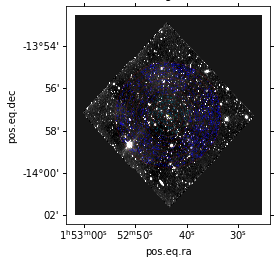

No handles with labels found to put in legend.


measuring mu
max_d is
3.823459215852308
binarea is
8.726023890130037
forearea is
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
n_ref is:
46.73901930758426
measuring mu
max_d is
1.5267160055575633
binarea is
1.3912974555027304
forearea is
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
n_ref is:
23.56206703608438
loading
CL1226


5721.938323415631 Mpc
number of 1 and 2 color objects inCL1226
(333,)
(203,)


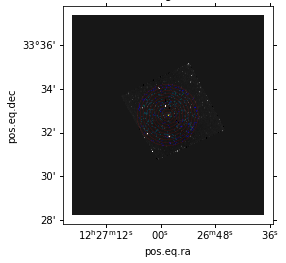

No handles with labels found to put in legend.


measuring mu
max_d is
2.3262988080443483
binarea is
3.2302376145016733
forearea is
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
n_ref is:
21.350811206666176
measuring mu
max_d is
2.0964378995965585
binarea is
2.6234179048468445
forearea is
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
n_ref is:
16.150393815758683
loading
ISCS1434+34
8648.202108099284 Mpc


number of 1 and 2 color objects inISCS1434+34
(370,)
(117,)


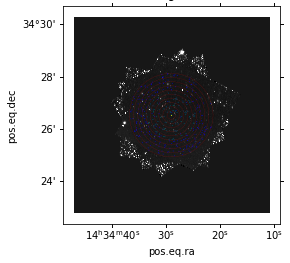

No handles with labels found to put in legend.


measuring mu
max_d is
4.018484915856993
binarea is
9.638915179130784
forearea is
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
n_ref is:
6.694623436196618
measuring mu
max_d is
2.4127827128960155
binarea is
3.4748806987880467
forearea is
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
n_ref is:
6.57327171533427
loading
RCS2345
6936.015409525792 Mpc
number of 1 and 2 color objects inRCS2345
(679,)
(82,)


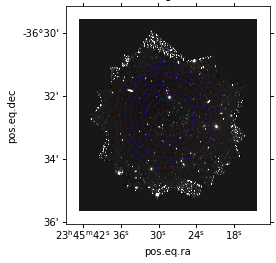

No handles with labels found to put in legend.


measuring mu
max_d is
3.4292597249906303
binarea is
7.019468532573391
forearea is
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
n_ref is:
18.63615746148789
measuring mu
max_d is
1.3638876031966551
binarea is
1.1103518936420826
forearea is
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
n_ref is:
14.185792888714753
loading
RDCS1252
8596.581343176696 Mpc


number of 1 and 2 color objects inRDCS1252
(3151,)
(79,)


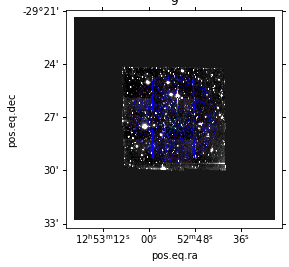

No handles with labels found to put in legend.


measuring mu
max_d is
6.251331862666309
binarea is
23.326446438356484
forearea is
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
n_ref is:
23.355767877266246
measuring mu
max_d is
1.8560581248582149
binarea is
2.0563006785280553
forearea is
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
n_ref is:
7.511415750667995
loading
XMMU1229
6404.083145464903 Mpc


number of 1 and 2 color objects inXMMU1229
(379,)
(104,)


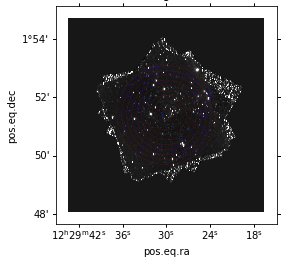

No handles with labels found to put in legend.


measuring mu
max_d is
3.1665145048863095
binarea is
5.985031453702735
forearea is
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
n_ref is:
12.772913014068811
measuring mu
max_d is
1.8915473485435466
binarea is
2.1356884914535232
forearea is
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
n_ref is:
8.692320593793667
loading
XMMU2235
9956.693263947349 Mpc


number of 1 and 2 color objects inXMMU2235
(692,)
(126,)


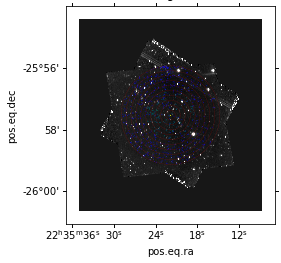

No handles with labels found to put in legend.


measuring mu
max_d is
4.631900410037172
binarea is
12.806247762162826
forearea is
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
n_ref is:
10.245942704621797
measuring mu
max_d is
2.3068090317152667
binarea is
3.1763383625754305
forearea is
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
n_ref is:
8.28010287088037


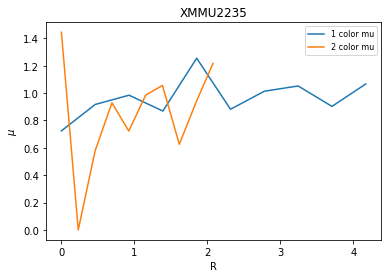

In [49]:
#mu calculation
#initialising cluster properties
cluster_name=("CL0152","CL1226" ,"ISCS1434+34","RCS2345","RDCS1252","XMMU1229","XMMU2235")    
#,"El_Gordo"     
#cluster_name=("CL0152","CL1226","CL1415","CL1604+4304","El_Gordo","ISCS1429","ISCS1432+33","ISCS1434+34","ISCS1438",
#              "RCS0220","RCS0337","RCS1511","RCS2345","RDCS0910","RDCS1252","XLSS0223","XMMU1229","XMMU2205","XMMU2235") 
minsep=(2.5, 1.4, 
        1.6,  1.7, 
        2.5, 1.7, 1.6)
z=(0.831,0.89,1.243,1.04,1.237,0.975,1.393 )
limiting=(27.4,26.9 , 26.9,27,27.6,27.9,27.5   )
minsep_2c=(1.0, 1.26, 
        0.96,  0.68, 
        0.75,  1.02, 0.8)
rad_bincount=10
m200=np.logspace(12,15,num=5, base=10.0)
print(m200)
r200=np.cbrt(3*m200/(pi*500*4*rohc))
colourcat=comcat4
#measurement code
def mu_measure(colourcat,forearea,    rad_bincount):
    max_d=np.max(colourcat["distance"])
    print("measuring mu")
    print("max_d is")
    print(np.max(colourcat["distance"]))

    bins=np.arange(0 ,max_d ,(max_d/rad_bincount), dtype=float)
    n_r=np.arange(0 ,max_d ,(max_d/rad_bincount), dtype=float)
    y=0
    #print(bins)
    for x in range(rad_bincount):
        lowlim=(x*max_d/rad_bincount)
        highlim=(x+1)*max_d/rad_bincount
        binarea=(np.pi*(highlim)**2)-(np.pi*(lowlim)**2)-forearea[x]
        contains_rlim=np.logical_and(colourcat["distance"]>lowlim,colourcat["distance"]<highlim)
        n_r[x]=colourcat[contains_rlim].shape[0]/binarea
        y=y+1
        
        


    n_ref=colourcat[np.logical_and(colourcat["distance"]>(max_d-1),colourcat["distance"]<max_d)].shape[0]/((np.pi*(max_d)**2)-(np.pi*(max_d-1)**2))
    print("binarea is")
    print(binarea)
    print("forearea is")
    print(forearea)
    
    print("n_ref is:")
    print(n_ref)
    mu_r=n_r/(n_ref)
    return mu_r , bins

#visualisation code to compare 2 different inputs
refarea=[0,0,0,0,0,0,0,0,0,0]
z_index=0

for name in cluster_name:
    colourcat=load_cat(name,z[z_index],minsep[z_index], minsep_2c[z_index],    rad_bincount)
    
    #forearea=foreground_adjust(name,z[z_index],colourcat[0],colourcat[1])
    mu_r=mu_measure(colourcat[0],refarea,    rad_bincount=10)
    mu_0=mu_measure(colourcat[2],refarea,    rad_bincount=10)
    pylab.plot(mu_r[1], mu_r[0], label="1 color mu")
    pylab.plot(mu_0[1], mu_0[0], label="2 color mu")
    z_index=z_index+1

    pylab.ylabel('$\mu$')
    pylab.xlabel('R')
    pylab.title(name)
    pylab.legend(fontsize=8)
    pylab.savefig("./pipeline_tests/mu_r_"+name+"_foreground_bright_1+2c.png")
    pylab.show
    pylab.close

#R_center=np.arange(0.001 ,max_d ,(max_d/rad_bincount), dtype=float)
#for k in range(m200.shape[0]):
#    rs=r_s(r200[k], con)
#    b_1=b1(m200[k],M_nl)

#    yval=vmu(R, zl, rs, deltac, rohc, b_1)
    
#    pylab.plot(R, yval,label="m200 is "+str(np.log(m200[k])))
#pylab.yscale('log')
#pylab.legend(fontsize=8)
#pylab.savefig("./pipeline_tests/mu_theomass_log.png")
#pylab.show    
#pylab.close    

<function matplotlib.pyplot.close(fig=None)>

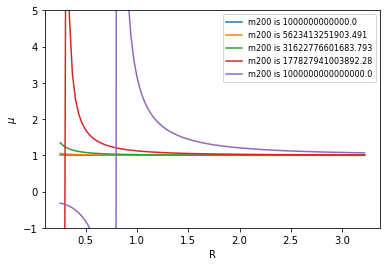

In [41]:
#visualisation of theoretical part
max_d=4
rad_bincount=10
R_center=np.arange(0.001 ,max_d ,(max_d/rad_bincount), dtype=float)
for k in range(m200.shape[0]):
    rs=r_s(r200[k], con)
    b_1=b1(m200[k],M_nl)

    yval=vmu(R, zl, rs, deltac, rohc, b_1)
    
    pylab.plot(R, yval,label="m200 is "+str(m200[k]))
#pylab.yscale('log')
pylab.legend(fontsize=8)
pylab.ylabel('$\mu$')
pylab.xlabel('R')
pylab.ylim(-1, 5)
#pylab.xlim(18, 35)
pylab.savefig("./pipeline_tests/mu_theomass.png")
pylab.show    
pylab.close   

[1.00000000e+12 5.62341325e+12 3.16227766e+13 1.77827941e+14
 1.00000000e+15]
2.7750138727456104
[0.         0.27750139 0.55500277 0.83250416 1.11000555 1.38750694
 1.66500832 1.94250971 2.2200111  2.49751249]
[20.66758891 30.31246373 27.28121735 20.07708637 25.71966619 22.54646062
 12.40055334 12.6761212   2.67462915  0.21755357]
0.15915494309189535
[129.85829094 190.45882672 171.41294405 126.14805406 161.60142873
 141.66359012  77.91497457  79.64641845  16.80519059   1.36692938]
[129.85829094 190.45882672 171.41294405 126.14805406 161.60142873
 141.66359012  77.91497457  79.64641845  16.80519059   1.36692938]
[0.         0.27750139 0.55500277 0.83250416 1.11000555 1.38750694
 1.66500832 1.94250971 2.2200111  2.49751249]
[20.66758891 30.31246373 27.28121735 20.07708637 25.71966619 22.54646062
 12.40055334 12.6761212   2.67462915  0.21755357]
1.3528170162811104
[15.27744599 22.40692079 20.16622871 14.84094754 19.01193279 16.66630472
  9.1664676   9.37016688  1.97708125  0.16081522]
[15

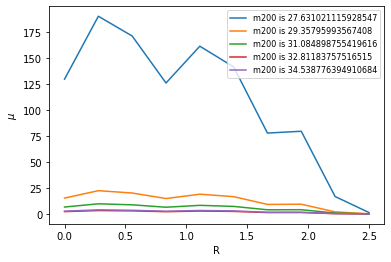

In [190]:
    
#C_stat calculations currently defunct

R_center=np.arange(0.001 ,max_d ,(max_d/rad_bincount), dtype=float)

upmedlimit=2.5
downmedlimit=1.5
medcount=colourcat["distance"][np.logical_and(colourcat["distance"]>downmedlimit,colourcat["distance"]<upmedlimit)].shape[0]
print(medcount)
Area=(np.pi*upmedlimit**2)-(np.pi*downmedlimit**2)
n_0_calc=n_0(medcount,Area)

print(str("n_0 ") )
print(n_0_calc)
mu_calc=vmu(R_center, zl, rs, deltac, rohc)
print(str("mu") )
print(mu_calc)
n_mod_calc=n_mod(n_0_calc,mu_calc,s)
print(str("n_mod"))
print(n_mod_calc)
C_stat=(n_mod_calc-n_r+(n_r*np.log(n_r/n_mod_calc)))
print(str("C_stat"))
print(C_stat)
#pylab.ylabel('$\mu$')
#pylab.plot(bins, C_stat)
#pylab.ylabel('C_stat')
#pylab.xlabel('R')
#pylab.savefig("./pipeline_tests/C_r_10bin_2c.png")
#pylab.show